In [516]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pickle
from multiprocessing import Pool
import random
import time

In [572]:
class Quantizer():
    def __init__(self, iters, dimC):
        self.iters = iters;
        self.C = None;
        self.A = None;
        self.dimC = dimC;
        
    def load(self, grads):
        self.grads = grads;
        self.d = np.shape(grads)[0];
        self.m = np.shape(grads)[1];
        self.betas = np.ones((self.m,));

    def objective(self, C, A):
        #print(np.shape(C), np.shape(A), np.shape(self.grads))
        total = 0;
        for i in range(self.m):
            total += self.betas[i]*np.square(np.linalg.norm(self.grads[:,i] - C@A))/np.square(np.linalg.norm(self.grads[:,i]))
        return total/self.m

    def find(self, u, sv):
        condition = u > ( (sv-1) / range(1,len(u)+1) )
        for i in reversed(range(len(condition))):
            if condition[i]:
                return i

    def projToSmplx(self, v):
        u = np.sort(v)[::-1]
        sv = np.cumsum(u)
        ind = self.find(u,sv)
        theta = (sv[ind]-1) / (ind+1)
        x = np.maximum(v - theta, 0)
        return x
    
    def grad_C(self, C, A):
        g = np.zeros(np.shape(C));
        for i in range(self.m):
            # add = self.betas[i]*np.expand_dims((C@A - self.grads[:,i]),1)@np.expand_dims(A, 1).T
            add = self.betas[i] * np.outer(C@A - self.grads[:,i], A)
            g += add
        return g

    def grad_A(self, C, A, index):
        g = np.zeros(np.shape(A));
        for i in range(self.m):
            add = self.betas[index]*(C.T@(C@A - self.grads[:,i]));
            g += add
        return g
    
    def compute(self, verbose):
        C = np.random.randn(self.d, self.dimC) if self.C is None else self.C
        A = np.ones((self.dimC)) * 1/self.dimC if self.A is None else self.A
        history = 0;
        for iter in range(self.iters):
            c_grad = self.grad_C(C, A);
            obj_value = self.objective(C, A);
            akc = (obj_value + (10/(10+iter)))/np.square(np.linalg.norm(c_grad));
            C = C - akc*c_grad
            a_grad = self.grad_A(C, A, 0);
            aka = (obj_value + (10/(10+iter)))/np.square(np.linalg.norm(a_grad));
            update = A - aka*a_grad
            A = self.projToSmplx(A - aka*a_grad);
        history = obj_value;
        self.C = C
        self.A = A;
        if(verbose):
            plt.plot(range(self.iters), history);
        return history;

    
    def quantize(self, dimC, g):
        dimC = min(dimC, self.dimC);
        a = cp.Variable(dimC);
        objective = cp.Minimize(cp.square(cp.norm(self.C@a - g)));
        constraints = [a >= 0, cp.sum(a) == 1];
        prob = cp.Problem(objective, constraints);
        opt = prob.solve("SCS");
        if(opt == float('inf')):
            a = self.A/sum(self.A);
        else:
            a = np.maximum(a.value, 0)/sum(np.maximum(a.value, 0));
        val = 0;
        index = np.random.choice(np.arange(dimC), p=a);
        return (index, val)


In [585]:
## Distributed Least Squares Toy Model ##
class AgentLSQ():
    def __init__(self, A, b, nagents, r, dimC, qflag):
        self.A = A
        self.b = b
        self.r = r;
        self.nagents = nagents;
        self.grads = [];
        self.PASS = True;
        iters = 10000;
        self.Q = Quantizer(iters, dimC);
        self.qflag = qflag;
    
    def grad(self, x, flag):
        lmbda = 0.1
        g = self.A.T@self.A@x - self.A.T@self.b + lmbda*2*x
        self.grads.append(np.expand_dims(g, 1));
        ch = -1;
        qh = -1;
        bits = 0;
        if(self.qflag != 0):
            flag = False; # always send full precision gradients if False;
        if(((len(self.grads)-self.r >= 0) or (len(self.grads) >= 2 and self.PASS)) and flag):
            G = np.hstack(self.grads);
            self.Q.load(G);
            start = time.time();
            ch = self.Q.compute(False);
            print("Time to compute C = ", time.time() - start);
            self.grads = [];
            self.PASS = False;
            print("Recomputing C... | Converged with value = ", ch)
            bits += self.Q.dimC*self.Q.d
        if(self.Q.C is not None and flag):
            bits += self.Q.dimC
            ghat, qh = self.Q.quantize(self.Q.C.shape[1], g)
            return (self.Q.C[:,ghat], ch, qh, bits)
        else:
            if(self.qflag == 2):
                g = np.sign(g);
            print("Sending full precision gradients")
            bits += len(g)
            return (g, ch, qh, bits)
        
    def objective(self, x):
        return np.square(np.linalg.norm(self.A@x-self.b)) + np.square(np.linalg.norm(x));
    
class DLSQ():
    def __init__(self, m, n, nagents, lr, r, dimC, qflag):
        A = np.random.random((m,n))
        z = np.random.random((n,))
        b = A@z + np.random.random((m))
        self.r = r;
        lmbda = 0.1
        print('Computing optimal...');
        self.optimal = np.square(np.linalg.norm(A@np.linalg.inv(A.T@A + lmbda*np.identity(n))@A.T@b-b))
        print('finished! | optimal = ', self.optimal)
        
        self.x = np.zeros((n,));
        self.m = m;
        self.n = n;
        self.nagents = nagents;
        self.lr = lr;  
        self.agents = self.distribute(A, b, nagents, r, dimC, qflag);
        
        self.A = A;
        self.b = b;
    
    def split(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

    def distribute(self, A, b, nagents, r, dimC, qflag):
        agents = [];
        splits = list(self.split(range(self.m), self.nagents))
        
        for sp in splits:
            agents.append(AgentLSQ(A[sp, :], b[sp], self.nagents, r, dimC, qflag));
        return agents;
    
    def computeGradFromLocal(self, x, flag):
        temp = np.zeros((self.n,))
        normalizing = 0;
        total_bits = 0;
        for n in range(self.nagents):
            localgrad, ch, qh, bits = self.agents[n].grad(self.x, flag)
            total_bits += bits;
            temp += localgrad
            normalizing += np.linalg.norm(localgrad)
        return (temp/normalizing, ch, qh, total_bits);
    
    def step(self, i, flag):
        g, ch, qh, bits = self.computeGradFromLocal(self.x, flag);
        ak = (self.objective()-self.optimal)/np.square(np.linalg.norm(g));
        xnext = self.x - min(ak, self.lr/(np.sqrt(i+1)))*g #min(ak, self.lr/(i+1))
        self.x = xnext + 0.01*(xnext - self.x);
        return (ch, qh, bits);
    
    def objective(self):
        return np.sum([self.agents[i].objective(self.x) for i in range(self.nagents)])
        
    def run(self, iters, verbose):
        history = [];
        compute_history = [];
        quantize_history = [];
        bit_history = [];
        i = 0;
        run = True;
        while(run and i < iters):
            print("Current objective value = ", np.square(np.linalg.norm(self.A@self.x - self.b)) + np.square(np.linalg.norm(self.x)))
            gap = (self.objective()-self.optimal)/self.optimal
            print("Iteration = " + str(i) + " | Relative Optimality gap = " + str(gap))
            print("")
            if(np.abs(gap) <= 1e-1):
                run = False;
            history.append(gap);
            
            flag = True
            if(i >= self.r):
                flag = (np.diff(history[-3::], 1, 0) >= 0).all()
                flag = not flag
                
            ch, qh, bits = self.step(i, flag);
            bit_history.append(bits);
            if(ch != -1):
                compute_history.append(ch)
            if(qh != -1):
                quantize_history.append(qh);
            i += 1;
        #if(verbose):
        #    plt.yscale('log')
        #    plt.plot(range(i), history);
        return (history, compute_history, quantize_history, bit_history);

In [595]:
## Execute DLSQ without Quantization ##
def execute(nagents, dimC, r, m=10, n=100, iters=1000, lr=1.0,verbose=False, qflag=0): 
    dlsqexe = DLSQ(m, n, nagents, lr, r, dimC, qflag);
    history, compute_history, quantize_history, bit_history = dlsqexe.run(iters, True)
    comp_ratio = np.sum(bit_history)/(n*nagents*len(history))
    print("Compression ratio achieved = ", comp_ratio);
    print("Optimal = ", dlsqexe.optimal)
    print("")
    print("Done...")
    print("___________________________________________________________________")
    return history, compute_history, quantize_history, bit_history, comp_ratio
    

In [599]:
# No quantization here #
h1, c1, q1, b1, cr1 = execute(nagents=5, dimC=5, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False, qflag=1)
h2, c2, q2, b2, cr2 = execute(nagents=5, dimC=5, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False, qflag=2)

Computing optimal...
finished! | optimal =  839.5109735220976
Current objective value =  1289658.5933379484
Iteration = 0 | Relative Optimality gap = 1535.2021867651051

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1209811.0735619052
Iteration = 1 | Relative Optimality gap = 1440.0902924650436

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1154895.257450247
Iteration = 2 | Relative Optimality gap = 1374.6763315445519

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1111005.7880444375
Iteration = 3 | Relative Optimality gap = 1322.3966392375967

Sending full

Sending full precision gradients
Current objective value =  291549.62462579395
Iteration = 82 | Relative Optimality gap = 346.29862947366126

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  287353.7042917903
Iteration = 83 | Relative Optimality gap = 341.3007552910926

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  283213.39660600276
Iteration = 84 | Relative Optimality gap = 336.36912530072766

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  279127.7172191686
Iteration = 85 | Relative Optimality gap = 331.5025669739432

Sending full precision gradients
Sending

Current objective value =  49897.357483160136
Iteration = 184 | Relative Optimality gap = 58.46833070398436

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  48776.950126622934
Iteration = 185 | Relative Optimality gap = 57.13391939223469

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  47673.33273341671
Iteration = 186 | Relative Optimality gap = 55.81950780282799

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  46586.37028253492
Iteration = 187 | Relative Optimality gap = 54.52493510258625

Sending full precision gradients
Sending full precision gradients
Sendi

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3630.0924127629655
Iteration = 285 | Relative Optimality gap = 3.372960009652288

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3612.1148465162705
Iteration = 286 | Relative Optimality gap = 3.3515535985929525

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3594.2275369395143
Iteration = 287 | Relative Optimality gap = 3.3302549489870716

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3576.430014589644

Current objective value =  2183.6551856951255
Iteration = 388 | Relative Optimality gap = 1.6522145387521021

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2173.0497282036304
Iteration = 389 | Relative Optimality gap = 1.6396149172970063

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2162.501085112143
Iteration = 390 | Relative Optimality gap = 1.6270831658240172

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2152.009036874037
Iteration = 391 | Relative Optimality gap = 1.6146190220007939

Sending full precision gradients
Sending full precision gradients
S

Sending full precision gradients
Current objective value =  1385.2907918130097
Iteration = 486 | Relative Optimality gap = 0.7052994043362812

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1379.3848412202904
Iteration = 487 | Relative Optimality gap = 0.6983132936468961

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1373.5193288607356
Iteration = 488 | Relative Optimality gap = 0.691375477142102

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1367.6941284949949
Iteration = 489 | Relative Optimality gap = 0.6844858037497347

Sending full precision gradients


Sending full precision gradients
Current objective value =  1080.3743126941183
Iteration = 551 | Relative Optimality gap = 0.34549602123893974

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1076.8575333648037
Iteration = 552 | Relative Optimality gap = 0.34136225589833247

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1073.3740288449555
Iteration = 553 | Relative Optimality gap = 0.3372681910554772

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1069.92370101626
Iteration = 554 | Relative Optimality gap = 0.33321370842161074

Sending full precision gradient

Sending full precision gradients
Current objective value =  924.9094261949792
Iteration = 611 | Relative Optimality gap = 0.16367782915308787

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  923.2132520851544
Iteration = 612 | Relative Optimality gap = 0.16171269417894632

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  921.5441034844316
Iteration = 613 | Relative Optimality gap = 0.159779646847353

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  919.9018486613352
Iteration = 614 | Relative Optimality gap = 0.15787852509101769

Sending full precision gradients
S

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  868.8451877085676
Iteration = 663 | Relative Optimality gap = 0.09949338348724003

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Compression ratio achieved =  1.0
Optimal =  839.5109735220976

Done...
___________________________________________________________________
Computing optimal...
finished! | optimal =  844.1605928994154
Current objective value =  1494695.4260910747
Iteration = 0 | Relative Optimality gap = 1769.629236502601

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1408406.2849103785
Iteration = 1 | Relative Optimality gap = 1667.4104156970461

Sending full precision gradients
Sending ful

Iteration = 52 | Relative Optimality gap = 676.6526775027756

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  564643.1578016507
Iteration = 53 | Relative Optimality gap = 667.8895907732542

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  557362.2682971928
Iteration = 54 | Relative Optimality gap = 659.2647597058625

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  550194.8909425385
Iteration = 55 | Relative Optimality gap = 650.7743962965352

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision 

Sending full precision gradients
Sending full precision gradients
Current objective value =  311468.9237924959
Iteration = 100 | Relative Optimality gap = 367.98550724626676

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  307529.0225608507
Iteration = 101 | Relative Optimality gap = 363.318445187657

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  303633.7813275955
Iteration = 102 | Relative Optimality gap = 358.70428782164385

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  299782.54811251926
Iteration = 103 | Relative Optimality gap = 354.14226280577566

Send

Sending full precision gradients
Current objective value =  154633.251109393
Iteration = 152 | Relative Optimality gap = 182.2059994817783

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  152397.53852349747
Iteration = 153 | Relative Optimality gap = 179.55773678898862

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  150185.83916688242
Iteration = 154 | Relative Optimality gap = 176.93792041413582

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  147997.92027644961
Iteration = 155 | Relative Optimality gap = 174.3462746236638

Sending full precision gradients
Sen

Sending full precision gradients
Sending full precision gradients
Current objective value =  33697.251071776955
Iteration = 236 | Relative Optimality gap = 38.95954495480458

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  32912.698977968255
Iteration = 237 | Relative Optimality gap = 38.03034187920513

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  32140.624037833742
Iteration = 238 | Relative Optimality gap = 37.11591936794394

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  31380.947860635402
Iteration = 239 | Relative Optimality gap = 36.21618455854792

Sen

Current objective value =  4430.37335825614
Iteration = 345 | Relative Optimality gap = 4.304263717473638

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4414.961638232941
Iteration = 346 | Relative Optimality gap = 4.286015820038699

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4399.5723603645765
Iteration = 347 | Relative Optimality gap = 4.2677933409656115

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4384.283936760929
Iteration = 348 | Relative Optimality gap = 4.249691922210945

Sending full precision gradients
Sending full precision gradients
Sendin

Sending full precision gradients
Current objective value =  3143.480291946841
Iteration = 447 | Relative Optimality gap = 2.781458357261066

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3133.3211392031785
Iteration = 448 | Relative Optimality gap = 2.769448177699066

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3123.220289130217
Iteration = 449 | Relative Optimality gap = 2.7575032190433952

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3113.167614430403
Iteration = 450 | Relative Optimality gap = 2.745621721211361

Sending full precision gradients
Sendi

Sending full precision gradients
Sending full precision gradients
Current objective value =  2261.5528618212456
Iteration = 553 | Relative Optimality gap = 1.7396409946184461

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2254.838942257569
Iteration = 554 | Relative Optimality gap = 1.7317158086325422

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2248.202906753925
Iteration = 555 | Relative Optimality gap = 1.7238901843040095

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2241.5422819359633
Iteration = 556 | Relative Optimality gap = 1.716027082326389

Se

Sending full precision gradients
Sending full precision gradients
Current objective value =  1712.2675639710842
Iteration = 652 | Relative Optimality gap = 1.0922480315194614

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1707.7747669987195
Iteration = 653 | Relative Optimality gap = 1.0869601900885317

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1703.2952925144748
Iteration = 654 | Relative Optimality gap = 1.0816874111504775

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1698.8345529800501
Iteration = 655 | Relative Optimality gap = 1.0764388309298965


Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1367.3221991660514
Iteration = 745 | Relative Optimality gap = 0.6869104288258604

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1364.3614367859677
Iteration = 746 | Relative Optimality gap = 0.6834314794596973

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1361.4005200863912
Iteration = 747 | Relative Optimality gap = 0.6799659111357843

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current ob

Iteration = 848 | Relative Optimality gap = 0.4047465933058576

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1124.4353216350412
Iteration = 849 | Relative Optimality gap = 0.40267779389186287

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1122.6557793257743
Iteration = 850 | Relative Optimality gap = 0.40062106355235955

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1120.9123423240605
Iteration = 851 | Relative Optimality gap = 0.3985631252981447

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending fu

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  979.4449249729784
Iteration = 957 | Relative Optimality gap = 0.23383361224815316

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  978.4977596252609
Iteration = 958 | Relative Optimality gap = 0.23275204717773115

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  977.4888768164992
Iteration = 959 | Relative Optimality gap = 0.23156320949089082

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current ob

0.2576 0.4008 0.8558


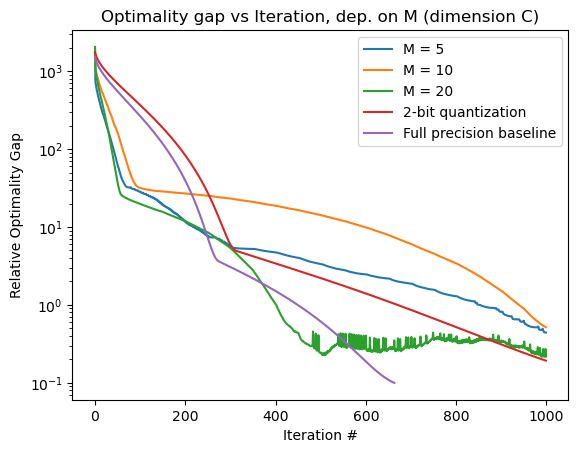

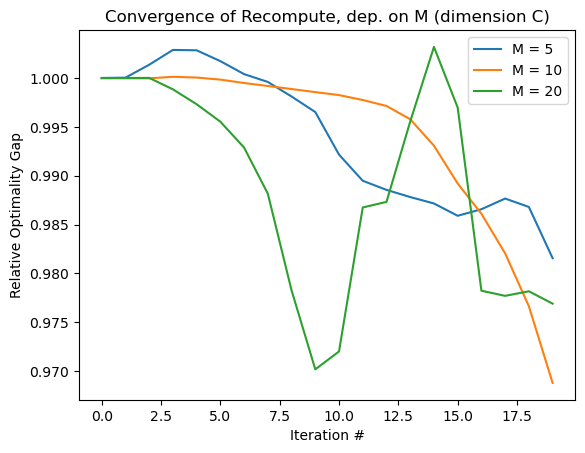

In [605]:
#exp1 = execute(nagents=5, dimC=5, r=50, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp2 = execute(nagents=5, dimC=10, r=50, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp3 = execute(nagents=5, dimC=20, r=50, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
print(exp1[4], exp2[4], exp3[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on M (dimension C)")
plt.plot(range(len(exp1[index])), exp1[index], label="M = 5")
plt.plot(range(len(exp2[index])), exp2[index], label="M = 10")
plt.plot(range(len(exp3[index])), exp3[index], label="M = 20")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on M (dimension C)")
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.plot(range(len(exp1[index])), exp1[index], label="M = 5")
plt.plot(range(len(exp2[index])), exp2[index], label="M = 10")
plt.plot(range(len(exp3[index])), exp3[index], label="M = 20")
plt.legend()

0.3464 0.4016


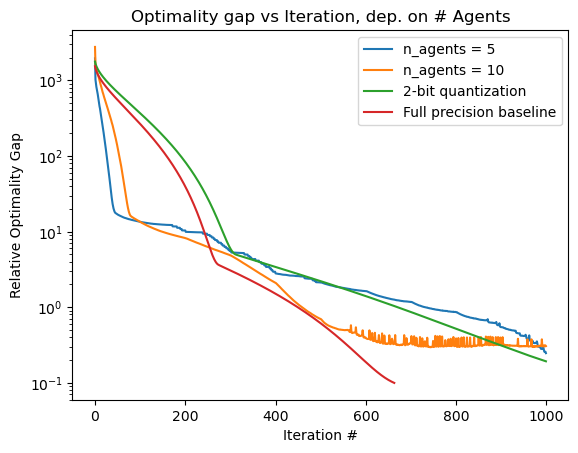

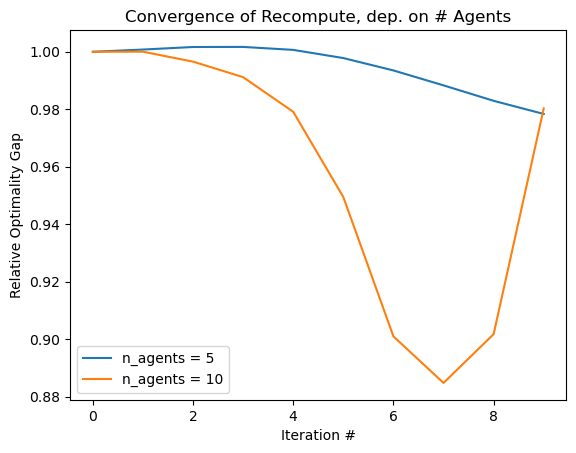

In [604]:
#exp4 = execute(nagents=5, dimC=10, r=100, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp5 = execute(nagents=10, dimC=10, r=100, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp6 = execute(nagents=50, dimC=10, r=100, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
print(exp4[4], exp5[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on # Agents")
plt.plot(range(len(exp4[index])), exp4[index], label="n_agents = 5")
plt.plot(range(len(exp5[index])), exp5[index], label="n_agents = 10")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on # Agents")
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.plot(range(len(exp4[index])), exp4[index], label="n_agents = 5")
plt.plot(range(len(exp5[index])), exp5[index], label="n_agents = 10")
plt.legend()

1.2443465491923642 0.4136 0.3328


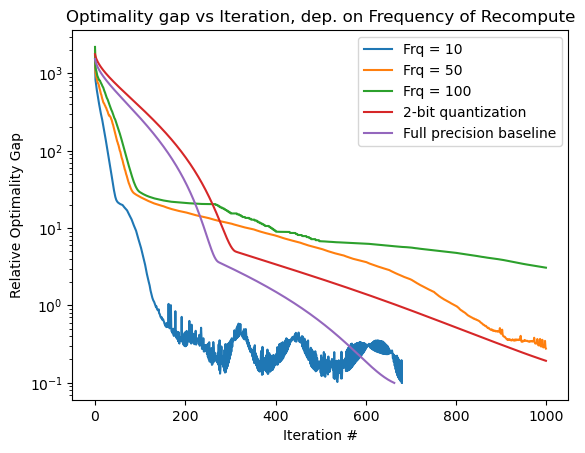

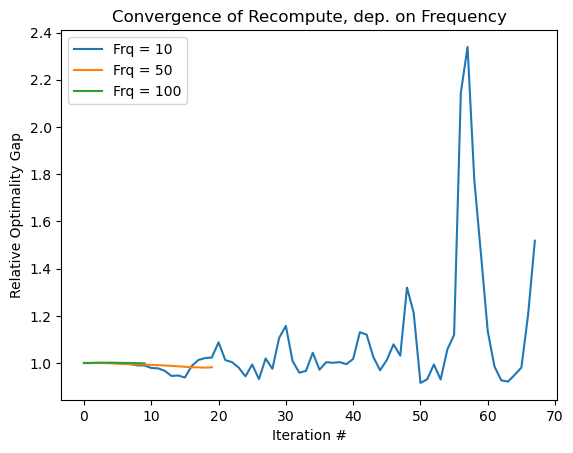

In [603]:
#exp7 = execute(nagents=5, dimC=10, r=10, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp8 = execute(nagents=5, dimC=10, r=50, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
#exp9 = execute(nagents=5, dimC=10, r=100, m=10000, n=50, iters=1000, lr=1.0, verbose=False)
print(exp7[4], exp8[4], exp9[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on Frequency of Recompute")
plt.plot(range(len(exp7[index])), exp7[index], label="Frq = 10")
plt.plot(range(len(exp8[index])), exp8[index], label="Frq = 50")
plt.plot(range(len(exp9[index])), exp9[index], label="Frq = 100")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on Frequency")
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.plot(range(len(exp7[index])), exp7[index], label="Frq = 10")
plt.plot(range(len(exp8[index])), exp8[index], label="Frq = 50")
plt.plot(range(len(exp9[index])), exp9[index], label="Frq = 100")
plt.legend()

In [539]:
meta = 'exp1 = execute(nagents=5, dimC=5, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp2 = execute(nagents=5, dimC=10, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp3 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp4 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp5 = execute(nagents=10, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp7 = execute(nagents=5, dimC=20, r=10, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp8 = execute(nagents=5, dimC=20, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp9 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | end'
e = {'1': exp1, '2': exp2, '3': exp3, '4': exp4, '5': exp5, '7': exp7, '8': exp8, '9': exp9, 'meta':meta}
with open('simplex_06042023.pickle', 'wb') as handle:
    pickle.dump(e, handle, protocol=pickle.HIGHEST_PROTOCOL)